In [ ]:
import math

from bloqade.pyqrack import StackMemorySimulator

from bloqade import qasm2

In [3]:
from typing import Any

import numpy as np
import bloqade.types
from kirin.ir import Method
from bloqade.types import Qubit, MeasurementResult

# Some types we will use, useful for type hints
from kirin.dialects.ilist import IList

from bloqade import squin

Register = IList[Qubit, Any]

@squin.kernel
def hello_world(theta: float) -> IList[MeasurementResult, Any]:
    """
    Prepare a Bell state and measure in a basis that might have a Bell violation
    """
    qubits = squin.qalloc(2)
    squin.h(qubits[0])
    squin.cx(qubits[0], qubits[1])
    squin.rx(theta, qubits[0])
    bits = squin.qubit.measure(qubits)
    return bits


# [kernel].print() prints the raw SSA, which is the intermediate representation of the kernel
# as used internally by Kirin.
hello_world.print()

func.func @hello_world(theta : !py.float) -> !Bottom {
  ^0(%hello_world_self, %theta):
  │      %0 = py.constant.constant 2 : !py.int
  │ %qubits = func.invoke qalloc(%0) : !py.IList[!py.Qubit, !Any] maybe_pure=False
  │      %1 = py.constant.constant 0 : !py.int
  │      %2 = py.indexing.getitem(%qubits, %1) : !py.Qubit
  │      %3 = func.invoke h(%2) : !py.NoneType maybe_pure=False
  │      %4 = py.constant.constant 0 : !py.int
  │      %5 = py.indexing.getitem(%qubits, %4) : !py.Qubit
  │      %6 = py.constant.constant 1 : !py.int
  │      %7 = py.indexing.getitem(%qubits, %6) : !py.Qubit
  │      %8 = func.invoke cx(%5, %7) : !py.NoneType maybe_pure=False
  │      %9 = py.constant.constant 0 : !py.int
  │     %10 = py.indexing.getitem(%qubits, %9) : !py.Qubit
  │     %11 = func.invoke rx(%theta : !py.float, %10) : !py.NoneType maybe_pure=False
  │   %bits = func.invoke measure(%qubits) : !py.MeasurementResult maybe_pure=False
  │           func.return %bits
} // func.func hello_wo

In [4]:
def GHZ_method_factory(nqubits: int) -> Method:
    @squin.kernel
    def GHZ_state() -> Register:
        qubits = squin.qalloc(nqubits)
        squin.h(qubits[0])
        for i in range(nqubits):
            squin.cx(qubits[i], qubits[i + 1])

        return qubits

    return GHZ_state


kernel = GHZ_method_factory(8)
kernel.print()

func.func @GHZ_state() -> !py.IList[!py.Qubit, !Any] {
  ^0(%GHZ_state_self):
  │                   %0 = py.constant.constant 8 : !py.int
  │              %qubits = func.invoke qalloc(%0) : !py.IList[!py.Qubit, !Any] maybe_pure=False
  │                   %1 = py.constant.constant 0 : !py.int
  │                   %2 = py.indexing.getitem(%qubits, %1) : !py.Qubit
  │                   %3 = func.invoke h(%2) : !py.NoneType maybe_pure=False
  │                   %4 = py.constant.constant IList(range(0, 8)) : !py.IList[!py.int, Literal(8,int)]
  │ %qubits_1, %qubits_2 = scf.for %i : !py.int in %4 -> !py.IList[!py.Qubit, !Any], !py.IList[!py.Qubit, !Any]
  │                        │ iter_args(%qubits_3 : !py.IList[!py.Qubit, !Any] = %qubits, %qubits_4 : !py.IList[!py.Qubit, !Any] = %qubits) {
  │                        │ %5 = py.indexing.getitem(%qubits_3 : !py.IList[!py.Qubit, !Any], %i : !py.int) : !py.Qubit
  │                        │ %6 = py.constant.constant 1 : !py.int
  │          

In [5]:
import cirq
from bloqade.cirq_utils import emit_circuit, load_circuit

def ghz_prep(nqubits: int) -> cirq.Circuit:
    """
    Builder function that returns a simple N-qubit
    GHZ state preparation circuit
    """
    qubits = cirq.LineQubit.range(nqubits)
    output = cirq.Circuit()
    output.append(cirq.H(qubits[0]))
    for i in range(nqubits - 1):
        output.append(cirq.CX(qubits[i], qubits[i + 1]))
    return output

print(ghz_prep(4))

# Load a cirq circuit into squin
kernel = load_circuit(
    ghz_prep(4),
    kernel_name="ghz_prep_cirq",  # Define the name of the kernel as if one were using @squin.kernel on a function
    register_as_argument=False,  # If the resulting kernel should take in a qubit register (True) or make a new one (False)
    return_register=True,  # If the resulting kernel should return the register of the qubits it acts on.
)

# Then, we can convert the circuit back to cirq.
# Note that this is **not possible** in a general case because
# cirq cannot represent complex control flow.
circuit2: cirq.Circuit = emit_circuit(kernel, ignore_returns=True)
print(circuit2)




(tilix:21674): GLib-GObject-WARNING **: 13:33:56.555: invalid (NULL) pointer instance

(tilix:21674): GLib-GObject-CRITICAL **: 13:33:56.555: g_signal_handlers_disconnect_matched: assertion 'G_TYPE_CHECK_INSTANCE (instance)' failed


0: ───H───@───────────
          │
1: ───────X───@───────
              │
2: ───────────X───@───
                  │
3: ───────────────X───
0: ───H───@───────────
          │
1: ───────X───@───────
              │
2: ───────────X───@───
                  │
3: ───────────────X───


Counts: Counter({'1100': 5, '0000': 5, '0011': 5, '1110': 5, '1010': 4, '0100': 4, '0110': 4, '0010': 3, '1101': 3, '0001': 3, '0111': 3, '1011': 2, '1001': 2, '1000': 1, '1111': 1})


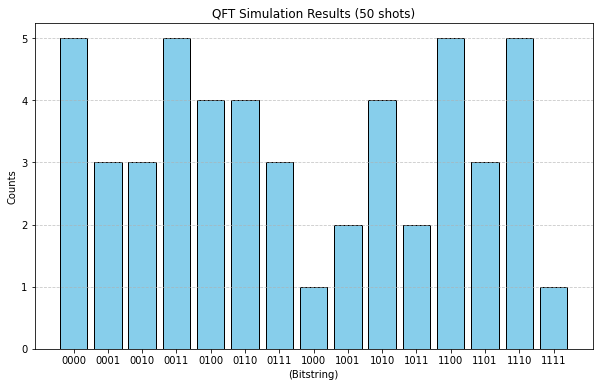

In [32]:
import math
from bloqade import qasm2
from bloqade.qasm2 import cu1, h
from bloqade import squin
import matplotlib.pyplot as plt
from collections import Counter

@qasm2.extended
def qft(qreg: qasm2.QReg, n: int):
    for k in range(n):
        h(qreg[k])
        for i in range(k + 1, n):
            cu1(qreg[i], qreg[k], math.pi / 2**(i - k))
    return qreg

@qasm2.extended
def main():
    q_reg = qasm2.qreg(4)
    c_reg = qasm2.creg(4)

    qft(q_reg, 4)

    qasm2.measure(q_reg, c_reg)

    return c_reg

#run simulation

sim = StackMemorySimulator(min_qubits=4)
n_shots = 50
results = []

for _ in range(n_shots):

    output = sim.run(main)
    bitstring = "".join(str(int(bit)) for bit in output)
    results.append(bitstring)

counts = Counter(results)
print("Counts:", counts)

sorted_keys = sorted(counts.keys())
sorted_values = [counts[k] for k in sorted_keys]

plt.figure(figsize=(10, 6))
plt.bar(sorted_keys, sorted_values, color='skyblue', edgecolor='black')
plt.xlabel('(Bitstring)')
plt.ylabel('Counts')
plt.title(f'QFT Simulation Results ({n_shots} shots)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()